# in silico matrisome definition
by Bruno Gideon Bergheim

This pipeline defines annotates input proteins using InterProScan and filters the resulting annotated proteins by defined ECM domains to create an in silico matrisome.

## InterProScan annotation

The domain annotation will be done using InterProScan. Please install InterProScan: 

### Install InterProScan

We are looking up a lot of domains therefore it is highly recommended to use a local version of InterProScan to annotate the domains.

IPR is available for linux and can be run on Windows computers using a Linux Subsystem (WSL).

1. **(if on Windows) Install the WSL**
2. **Install Interproscan**

    See [here](https://interproscan-docs.readthedocs.io/en/latest/InstallationRequirements.html) for instructions

    At the time of writing the instructions were:
    ```shell
    #checking requirements versions
    uname -a
    perl -version
    python3 --version
    java -version

    #downloading interproscan
    mkdir my_interproscan
    cd my_interproscan
    wget https://ftp.ebi.ac.uk/pub/software/unix/iprscan/5/5.57-90.0/interproscan-5.57-90.0-64-bit.tar.gz
    wget https://ftp.ebi.ac.uk/pub/software/unix/iprscan/5/5.57-90.0/interproscan-5.57-90.0-64-bit.tar.gz.md5
    #checking if the download was completed
    md5sum -c interproscan-5.57-90.0-64-bit.tar.gz.md5

    #unpacking interproscan
    tar -pxvzf interproscan-5.57-90.0-*-bit.tar.gz
    cd interproscan-5.57-90.0

    #setup
    python3 initial_setup.py

    #test
    ./intersproscan.sh
    ```

3. **Run interproscan**

    We want to run intersprscan on all fasta sequences. Therefore we run it in a loop:

    e.g. for this analysis the command was:
    ```shell
    	sudo ./interproscan.sh -i $file -o $file.tsv -f tsv,xml -dra -cpu 14 -go -pa;
    ```

    where:
    -f xml,tsv => specifies xml and tsv output file
    -go => activates go-term annotation
    -pa => activates pathway annotation

4. **Install SignalP, TMHMM and Phobius**

To get all annotations three licences databases have to be added.

http://phobius.sbc.su.se/data.html

http://www.cbs.dtu.dk/services/SignalP/

http://www.cbs.dtu.dk/services/TMHMM/

They are available for scientific use if the licence agreement is accepted. the download files will be send to your email.

After downloading the files they can be moved to the correct folders:

phoebius:
```shell
mv -v [download path]/* /my_intersproscan/interproscan-5.57-90.0/bin/phobius/1.01/
```
SignalP:
```shell
mv -v [download path]/* /my_intersproscan/interproscan-5.57-90.0/bin/signalp/4.1/
```

TMHMM:
```shell
mv -v [download path]/* /my_intersproscan/interproscan-5.57-90.0/bin/tmhmm/2.0c/
```

### Run Interproscan  for the dataset

The general command for running the domain annotation is:

```shell
  
    sudo ./interproscan.sh -i input/[Species_name].fasta -o output/[Species_name]/full_annotations.tsv -f tsv,xml -dra -cpu 14 -appl -go -pa;

```

## Required packages
Please install the following packages in a virtual environment.

```shell
python -m venv .venv
.\.venv\Scripts\activate
pip install ipykernel pandas numpy openpyxl biopython tqdm
```

In [1]:
#Input/Output
from pathlib import Path # A module for interacting with file paths

#Sequence manipulation
import re # A module for working with regular expressions
from Bio import SeqIO, AlignIO, SeqRecord, SeqFeature, SearchIO, Phylo, BiopythonWarning, BiopythonParserWarning # Biopython is a set of python tools for bioinformatics. SeqIO provides input/output function for sequence files, AlignIO for alignment files, SeqRecord for sequence records, SeqFeature for sequence features, SearchIO for searching sequences, Phylo for working with phylogenetic trees and BiopythonWarning, BiopythonParserWarning for the warning.
from Bio.Seq import Seq # module that defines the Seq object, which is the basic container for sequence data

#Data manipulation and analysis
import pandas as pd # A powerful data manipulation library
import numpy as np # A library for working with arrays and numerical operations
import openpyxl # A library for working with Excel files
from collections import namedtuple # A module that defines a named tuple object, which is a subclass of tuple
from collections import Counter # A module that provides a dictionary-like object for counting occurrences of items in a list or other iterable

#Logging, progress tracking, and display
import logging #A module for logging messages
logging.basicConfig(filename="logs/last_run.log", level=logging.DEBUG) # Logging configuration
from tqdm import tqdm # A library for creating progress bars
from IPython.display import display, Markdown # A module for displaying Markdown in Jupyter notebooks

#Other
import warnings # A module for working with warnings
from typing import Dict, Set # A module for working with types

## Input control
First, we need to set some constants and create the nessecary folder structure.

This pipeline expects the input proteomes as .fasta files in a folder called "input" 

In [2]:
# InterProScan directory
interproscan_directory = "./my_interproscan/interproscan-5.57-90.0"
# List of column names for the  InterProScan results
column_names = ["Accession", "MD5_digest", "Seq_length", "Analysis", "Signature_accession", "Signature_description", "Start", "End", "e-value", "Status", "Date", "InterPro_accessions", "InterPro_description", "Go-terms", "pathways"]

# Get list of FASTA files in the input directory
files = [file for file in Path("input").glob("**/*.fasta") if file.is_file()]

# Get list of species from the file names
species_list = [file.stem for file in files]

#create output folders for each species
for species in species_list:
    seq_output_path = Path(f"output/Sequences/{species}/")
    seq_output_path.mkdir(parents= True,exist_ok=True)

orthofinder_out_dir = Path("output/orthofinder_input/matrisome")
orthofinder_core_out_dir = Path("output/orthofinder_input/core")
taxonomy = pd.read_csv("lib/taxgroups.csv",index_col=0)

We double check the input proteomes and count the number of proteins

In [3]:
# Assuming 'files' is a list containing paths to your FASTA files
markdown = "|Species|Proteome size|\n"
markdown += "|-------|-------:|\n"

for file in tqdm(files):
    with open(file, "r") as f:
        num_sequences = sum(line.startswith('>') for line in f)
    markdown += "|" + str(file).split("/")[-1].split(".")[0] + "|" + str(num_sequences) + "|\n"

display(Markdown(markdown))

  0%|          | 0/47 [00:00<?, ?it/s]

100%|██████████| 47/47 [00:11<00:00,  4.18it/s]


|Species|Proteome size|
|-------|-------:|
|input\Acropora_cervicornis|30325|
|input\Acropora_digitifera|23523|
|input\Acropora_hyacinthus|21036|
|input\Acropora_millepora|26840|
|input\Acropora_muricata|13538|
|input\Actinia_tenebrosa|23842|
|input\Amphimedon_queenslandica|43437|
|input\Aurelia_aurita|27044|
|input\Beroe_ovata|18661|
|input\Branchiostoma_belcheri|31614|
|input\Branchiostoma_floridae|38648|
|input\Branchiostoma_lanceolatum|38783|
|input\Caenorhabditis_elegans|716|
|input\Calvadosia_cruxmelitensis|74577|
|input\Capitella_teleta|32415|
|input\Cassiopea_xamachana|31459|
|input\Clytia_hemispherica|25087|
|input\Coturnix_japonica|703|
|input\Danio_rerio|925|
|input\Drosophila_melanogaster|1191|
|input\Ephydatia_muelleri|39329|
|input\Exaiptasia_diaphana|27767|
|input\Homo_sapiens|1024|
|input\Hydractinia_echinata|28838|
|input\Hydractinia_symbiolongicarpus|22035|
|input\Hydra_viridissima|25978|
|input\Hydra_vulgaris|36059|
|input\Mnemiopsis_leidyi|16548|
|input\Monosiga_brevicollis|9202|
|input\Montipora_aequituberculata|28717|
|input\Montipora_foliosa|10295|
|input\Morbakka_virulenta|28983|
|input\Mus_musculus|791|
|input\Myxobolus_honghuensis|15433|
|input\Nematostella_vectensis|32495|
|input\Pleurobrachia_bachei|32207|
|input\Pocillopora_damicornis|14101|
|input\Pocillopora_verrucosa|12675|
|input\Porites_asteroides|18763|
|input\Renilla_reniformis|12689|
|input\Salpingoeca_rosetta|11725|
|input\Schmidtea_mediterranea|23657|
|input\Stylophora_pistillata|25769|
|input\Thelohanellus_kitauei|14792|
|input\Trichoplax_specH2|12150|
|input\Tricoplax_adhaerens|11518|
|input\Xenia_spec|20661|


We have to make sure that the sequence names in the dataset are compatible with the downstrean analysis.

In [4]:
# create a list of fasta files for input
input_fasta_files = [Path("input/{species}.fasta".format(species = species)) for species in species_list]
# Add Species names to the protein IDs
for fasta_file in tqdm(input_fasta_files):
    species = fasta_file.stem
    new_records = []
    with fasta_file.open("r") as f:
        for record in SeqIO.parse(f, "fasta"):
            # Remove "*" from the end of the sequence
            if record.seq[-1] == "*":
                record.seq = record.seq[:-1]
            # Replace "|" and "/" in the ID with "_"
            record.id = record.id.replace("|", "_").replace("/", "_")
            # Add the species name to the start of the ID if it's not already there
            if not record.id.startswith(species):
                record.id = f"{species}_{record.id}"
            new_records.append(record)
    # write the cleaned up records to the same file
    with fasta_file.open("w") as f:
        SeqIO.write(new_records, f, "fasta")

100%|██████████| 47/47 [00:29<00:00,  1.58it/s]


Now we can use InterProScan to annotate the proteins in the input proteomes.<br>
The following code will create the nessecary commands to start the annoation.

In [5]:
# this code generates a command line commadn that can be copy pasted.
# This step is manual becasue the domain annotation is time consuming so I want to make sure that the user has manaual control 

def replace_uppercase_with_lowercase(match):
    return match.group(0).lower()[0]

for fasta_file in input_fasta_files:
    species = fasta_file.stem
    output_dir = Path(f"output/interproscan_results/{species}")
    output_tsv = output_dir / f"{species}.fasta.tsv"
   
    # Create the output directory if it doesn't exist
    if not output_dir.exists():
        output_dir.mkdir(parents=True)
    # Check if the output files already exist and are not empty
    if not output_tsv.exists() or output_tsv.stat().st_size == 0:
        command = f'\u001b[33m./my_interproscan/interproscan-5.57-90.0/interproscan.sh\033[0m'
        command += f' \033[1;32;1m--input\033[0m /mnt/{fasta_file.resolve()}' 
        command += f' \033[1;32;1m--output-dir\033[0m /mnt/{output_dir.resolve()}'
        command += ' \033[1;32;1m--formats\033[0m tsv'
        command += ' \033[1;32;1m-cpu\033[0m 14' 
        command += f' \033[1;32;1m--tempdir\033[0m /mnt/{output_dir.resolve()}'
        command += ' \033[1;32;1m--disable-precalc --disable-residue-annot --goterms --pathways\033[0m'
        command = command.replace("\\","/")
        command = re.sub(r"[A-Z]:",replace_uppercase_with_lowercase,command)
        print(command)

## Run InterProScan
Annotating the proteomes takes a lot of time (in the order of hours for each dataset) therfore you have to manually run this command to make sure it is not run unessecarily.

In [6]:
for species in species_list:
    output_dir = Path(f"output/interproscan_results/{species}")
    output_tsv = output_dir / f"{species}.fasta.tsv"
    output_xml = output_dir / f"{species}.fasta.xml"
    # Check if the output files exist and have a size greater than 0
    if output_tsv.exists() and output_tsv.stat().st_size > 0:
        print(f"\033[0m{species} : \033[1;32;1m DONE \033[0m")
    else:
        error_message = f"{species} : \033[1;31;1m ERROR\033[0m"
        if not output_tsv.exists() or output_tsv.stat().st_size == 0:
            error_message += f" tsv file is missing or empty."
        print(error_message)

Acropora_cervicornis :  DONE 
Acropora_digitifera :  DONE 
Acropora_hyacinthus :  DONE 
Acropora_millepora :  DONE 
Acropora_muricata :  DONE 
Actinia_tenebrosa :  DONE 
Amphimedon_queenslandica :  DONE 
Aurelia_aurita :  DONE 
Beroe_ovata :  DONE 
Branchiostoma_belcheri :  DONE 
Branchiostoma_floridae :  DONE 
Branchiostoma_lanceolatum :  DONE 
Caenorhabditis_elegans :  DONE 
Calvadosia_cruxmelitensis :  DONE 
Capitella_teleta :  DONE 
Cassiopea_xamachana :  DONE 
Clytia_hemispherica :  DONE 
Coturnix_japonica :  DONE 
Danio_rerio :  DONE 
Drosophila_melanogaster :  DONE 
Ephydatia_muelleri :  DONE 
Exaiptasia_diaphana :  DONE 
Homo_sapiens :  DONE 
Hydractinia_echinata :  DONE 
Hydractinia_symbiolongicarpus :  DONE 
Hydra_viridissima :  DONE 
Hydra_vulgaris :  DONE 
Mnemiopsis_leidyi :  DONE 
Monosiga_brevicollis :  DONE 
Montipora_aequituberculata :  DONE 
Montipora_foliosa :  DONE 
Morbakka_virulenta :  DONE 
Mus_musculus :  DONE 
Myxobolus_honghuensis :  DONE 
Nematostella_vectens

## Domain based filtering of matrisomal proteins
Now we can use the defined domains to filter out proteins that are likely part of the matrisome.
first we load the inclusion and exclusion domains defined by Naba et al. 2012 

In [7]:
print("Loading InterProScan Domains",end = " ")
# the inclusion and exclusion domains can be downloaded from the Naba et al 2012 supplementary information
naba_include_df = pd.read_excel("lib/Naba_et_al_Identifiers.xlsx", sheet_name=0,index_col=0)
category_inclusion_groups = naba_include_df.groupby("Division / Category")
naba_exclude_df = pd.read_excel("lib/Naba_et_al_Identifiers.xlsx", sheet_name=1,index_col=0)
category_exclusion_groups = naba_exclude_df.groupby("Division / Category")
# reading the InterPro Scan identifiers
naba_filter = {}
categories = []
for group,df in category_inclusion_groups:
    categories.append(group)
    inculsion_IPRs = set(df["InterPro Accession Number"])
    try:
        exclusion_IPRs = set(category_exclusion_groups.get_group(group)["InterPro Accession Number"])
    except KeyError:
        exclusion_IPRs = set()
    naba_filter[group] = (inculsion_IPRs,exclusion_IPRs)
print('\033[92m' + '\u2713' + '\033[0m')

# create a csv document to hold statistical information 
statistics_doc = Path("output/statistics.csv")
if statistics_doc.exists():
    statistics = pd.read_csv(statistics_doc,index_col = [0,1])
else:
    statistics= pd.DataFrame(columns = ["taxonomic_id","species_id"]).set_index(["taxonomic_id","species_id"])

Loading InterProScan Domains ✓


Then we define the functions that filter and transfer the domain annotations

In [8]:
def determine_classification(annotation_IPRs,naba_filter_dict):
    """
    This function takes in a list of domain IDs (annotation_IPRs) and a dictionary (naba_filter_dict) that defines the categories of the matrisome and the domains that are included or excluded in each category. 
    It returns a dictionary where each key is a category of the matrisome and the value is a Boolean indicating whether the sequence belongs to that category or not.
    
    Args:
    - annotation_IPRs (list): a list of domain IDs that have been annotated with InterPro (IPR) domains.
    - naba_filter_dict (dict): a dictionary that defines the categories of the matrisome and the domains that are included or excluded in each category. Each key in the dictionary represents a category of the matrisome, and the value is a tuple of two lists. The first list contains the domains that are included in the category, and the second list contains the domains that are excluded from the category.
    
    Returns:
    - filter_result (dict): a dictionary where each key is a category of the matrisome and the value is a Boolean indicating whether the sequence belongs to that category or not.
    """
    filter_result = {}
    for category,(inclusion,exclusion) in naba_filter_dict.items():
        filter_result[category] = False #initially the sequence does not belong to a matrisome category
        positive_filter = (annotation_IPR in inclusion for annotation_IPR in annotation_IPRs) #creates a boolean tuple where each domain id is checked for the positive categories
        negative_filter = (annotation_IPR in exclusion for annotation_IPR in annotation_IPRs) #creates a boolean tuple where each domain id is checked for the negative categories
        if any(positive_filter) and not any(negative_filter): #if any domain is in the naba domains for the category but non is in the exclusion domains
            filter_result[category] = True
    return pd.Series(filter_result)

def annotate_sequence(sequence, annotation_hits):
    """
    Takes a Biopython SeqRecord and a list of biopythoon.SearchIO.Hit objects.
    Transfers the Hits as SeqFeatures to the sequences, adds the molecule type and returns the annotated sequence.
    
    Args:
    - sequence (SeqRecord): a Biopython SeqRecord object representing the sequence to be annotated.
    - annotation_hits (DataFrame): a DataFrame object containing the annotation hits, with columns 'InterPro_description', 'Analysis', 'Start', 'End', 'e-value', 'InterPro_accessions', 'Signature_description', 'Go-terms', 'pathways'
    
    Returns:
    - sequence (SeqRecord): the annotated sequence with added SeqFeature object.
    """
    new_seq_features = []
    for seq_id,hit_row in annotation_hits.iterrows():
        feature_name = hit_row['InterPro_description']
        if feature_name == "-":
            feature_name = hit_row['Signature_description']
        seq_feature = SeqFeature.SeqFeature(
            id=hit_row['InterPro_description'],
            type=hit_row['Analysis'],
            location=SeqFeature.FeatureLocation(int(hit_row['Start']), int(hit_row['End'])),
            qualifiers={
                'e-value': hit_row['e-value'],
                'interpro_accession': hit_row['InterPro_accessions'],
                'description': feature_name,
                'go_terms': hit_row['Go-terms'],
                'pathways': hit_row['pathways'],
                'signature_description': hit_row['Signature_description'],
                "region_name": feature_name
            }
        )
        new_seq_features.append(seq_feature) #adds the new feature
    sequence.features = new_seq_features # repalces the domain annotations with the new annotations
    sequence.annotations["molecule_type"] = "protein" #adds the molecule type proteins
    return sequence

Now we can run the filtering and organize the resulting proteins into individual folders

In [9]:
for species in tqdm(species_list):
    ##### CHECK if output files already exist
    try:
        tax_group = taxonomy.loc[species,"Tax_group"]
    except KeyError:
        new_tax_group = input(f"No taxonomic group for {species}. Please enter: ")
        taxonomy.loc[species,"Tax_group"] = new_tax_group
        taxonomy.to_csv("lib/taxgroups.csv")
    
    seq_info = pd.DataFrame()
    sequences = SeqIO.parse(Path(f"input/{species}.fasta"),"fasta")
    file_path = Path(f"output/interproscan_results/{species}/{species}.fasta.tsv")
    if not file_path.exists():
        print(f"\033[1;31;1m ERROR\033[0m Annotations file not found: {file_path}")
        break
    try:
        annotations = pd.read_csv(file_path,
                        sep = "\t",
                        names = column_names,
                        index_col="Accession")
        seq_annotation_groups = annotations.groupby("Accession")
    except IOError:
        print(f"\033[1;31;1m ERROR\033[0m Failed to read annotations for {species}.")
        break
    
    matrisome_sequences = []
    core_matrisome_sequences = []
    matrisome_sequence_ids = []
    core_matrisome_sequence_ids = []
    category_seqs = {cat:list() for cat in naba_include_df.index.unique()} #creates an empty list
    category_seqs["Matrisome"] = list() #add an empty list for the overall matrisome
    for seq_record in sequences:
        try:
            seq_annotation_hits = seq_annotation_groups.get_group(seq_record.id) #returns a pandas.DataFrame with all annotations for this sequence
        except KeyError: #if there are no annotations for that sequence look at the next sequence immediately
                continue
        IPR_ids = seq_annotation_hits.InterPro_accessions
        filter_result = pd.Series(determine_classification(annotation_IPRs=IPR_ids,naba_filter_dict= naba_filter))
        if any(filter_result.values): #if the sequence has at least one of the matrisome categories
            annotated_sequence = annotate_sequence(sequence = seq_record, annotation_hits = seq_annotation_hits)# only annotate the sequences that ar ein the matrisome
            category_seqs["Matrisome"] += [annotated_sequence] #add sequence to the overall matrisome
            matrisome_sequence_ids.append(seq_record.id)
            for category,is_in_category in filter_result.items():
                if is_in_category: #the sequence is in the category
                    category_seqs[category] += [annotated_sequence] # add sequence to the matrisome category
                    seq_info.loc[seq_record.id,category] = True

    seq_output_path = Path(f"output/Sequences/{species}/")
    seq_output_path.mkdir(parents= True,exist_ok=True)
    seq_info.to_csv(seq_output_path / "category_info.csv")

    id_output = Path(f"output/Sequences/{species}_ecm_subset.txt")
    with open(id_output,"w") as subset_out:
        subset_out.write("\n".join(matrisome_sequence_ids))

    with warnings.catch_warnings(): 
        warnings.simplefilter("ignore",BiopythonWarning)
        for category,cat_seqs in category_seqs.items():
            file_category = category.replace(" ","_").lower()
            cat_size = 0 #all categories start with zero sequences
            if len(cat_seqs) > 0:
                out_file = seq_output_path / f"{species}_{file_category}.gb"
                cat_size = SeqIO.write(cat_seqs,out_file,"gb")
            if category == "Matrisome":
                SeqIO.write(cat_seqs,orthofinder_out_dir / f"{tax_group}_{species}.fasta","fasta")
            if category == "Core matrisome":
                SeqIO.write(cat_seqs,orthofinder_core_out_dir / f"{tax_group}_{species}.fasta","fasta")
            statistics.loc[(tax_group,species),file_category] = cat_size
            statistics.to_csv(statistics_doc)

  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\gideon.b\AppData\Local\Temp\ipykernel_7196\2360215836.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  seq_info.loc[seq_record.id,category] = True
C:\Users\gideon.b\AppData\Local\Temp\ipykernel_7196\2360215836.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  seq_info.loc[seq_record.id,category] = True
C:\Users\gideon.b\AppData\Local\Temp\ipykernel_7196\2360215836.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  seq_info.loc[seq_re

<Axes: xlabel='taxonomic_id,species_id'>

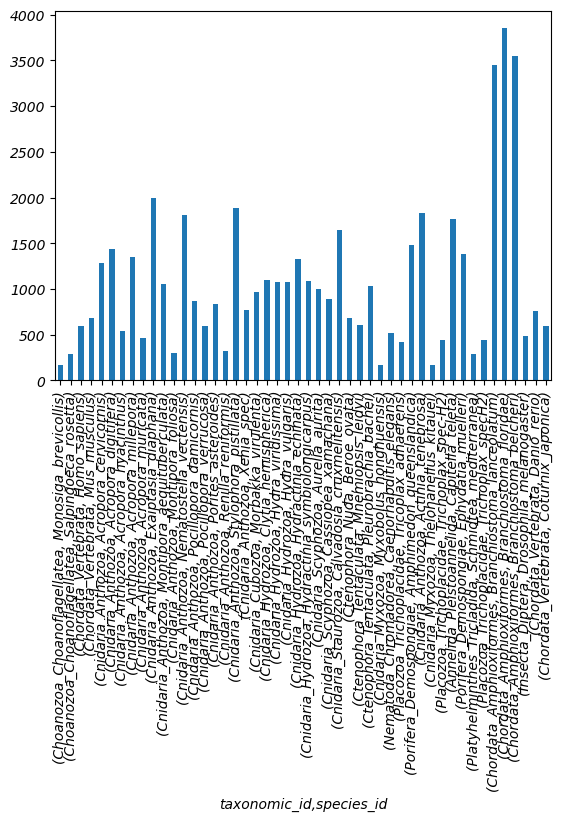

In [10]:
statistics.matrisome.plot(kind="bar")